In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

In [2]:
import pandas as pd

# Cargar el conjunto de datos desde un archivo CSV
data_path = r"C:\Proyectos programación\Modelos\consumo_casa.csv"
data = pd.read_csv(data_path)

# Eliminar la primera columna (asumiendo que se llama 'Unnamed: 0')
data.drop(columns=['Unnamed: 0'], inplace=True)

# Calcular la columna 'otros'
data['otros'] = data['Medidor [W]'] - data[['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system']].sum(axis=1)

# Convertir la columna 'Fecha' a tipo datetime si no lo está
data['Fecha'] = pd.to_datetime(data['Fecha'])

print(data)


                     Fecha  Medidor [W]  Refrigerator  Clothes washer  \
0      2017-06-07 00:00:00      228.887         134.6             1.0   
1      2017-06-07 00:01:00      231.814         134.6             0.2   
2      2017-06-07 00:02:00      230.971         131.3             0.3   
3      2017-06-07 00:03:00      231.878         131.3             0.0   
4      2017-06-07 00:04:00      189.225           0.0             0.1   
...                    ...          ...           ...             ...   
194118 2017-10-22 23:55:00       88.272           0.1             1.4   
194119 2017-10-22 23:56:00       86.386           1.0             1.3   
194120 2017-10-22 23:57:00       85.766           0.0             1.8   
194121 2017-10-22 23:58:00       87.665           0.4             0.0   
194122 2017-10-22 23:59:00       86.988           0.3             0.7   

        Clothes Iron  Computer  Oven  Play   TV  Sound system    otros  
0                0.0       0.3   0.1   0.0  0.0   

In [3]:
# Dividir los datos en características (X) y etiquetas (y)
X = data[['Fecha', 'Medidor [W]']]
y = data.drop(columns=['Fecha', 'Medidor [W]'])

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos de entrada
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.drop(columns=['Fecha']))
X_test_scaled = scaler_X.transform(X_test.drop(columns=['Fecha']))

# Normalizar los datos de salida
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Preparar los datos para LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 7  # Utilizaremos los últimos 7 días como datos de entrada
X_train_lstm, y_train_lstm = create_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_lstm, y_test_lstm = create_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)

print(X_train_lstm)

# Construir el modelo LSTM
model = Sequential()
model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=y_train_lstm.shape[1]))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Normalizar los datos de entrada para X_val
X_val_scaled = scaler_X.transform(X_val.drop(columns=['Fecha']))

# Normalizar los datos de salida para y_val
y_val_scaled = scaler_y.transform(y_val)

# Preparar los datos para LSTM de X_val y y_val
X_val_lstm, y_val_lstm = create_dataset(X_val_scaled, y_val_scaled, TIME_STEPS)

# Compilar el modelo con la métrica de precisión
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con métricas de precisión
history = model.fit(X_train_lstm, y_train_lstm, epochs=2, batch_size=32, validation_data=(X_val_lstm, y_val_lstm))


[[[0.02945975]]

 [[0.01151024]]

 [[0.60493139]]

 ...

 [[0.07507655]]

 [[0.1166746 ]]

 [[0.0768797 ]]]
Epoch 1/2
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 2/2
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0040 - val_loss: 0.0041


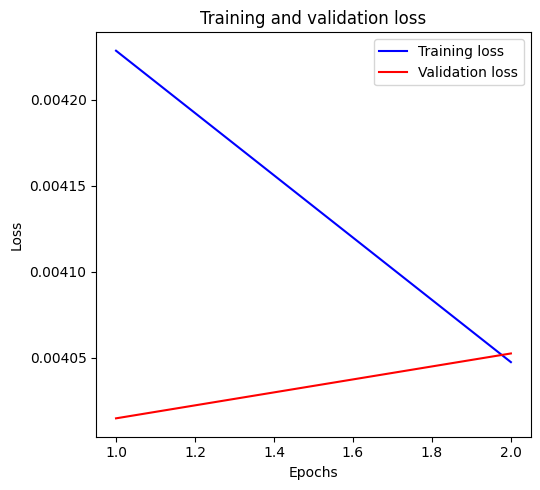

In [7]:
import matplotlib.pyplot as plt
# Graficar las curvas de pérdida y precisión
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Graficar las curvas de pérdida y precisión
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()